# Don't Overfit! II 

we have a binary classification task. 300 columns, 250 training samples and 79 times more samples in test data! We need to be able to build a model without overfitting.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### In this project, following actions will be performmed!

- EDA on features and try to get some insights

In [3]:
train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 589.9 KB


### No Null values

In [5]:
train.isnull().any().any()

False

### Separate target from the data

In [6]:
x = train.iloc[:,2:]
y = train.iloc[:,1]
X_test = test.drop(['id'], axis=1)
x_test = test.drop(['id'], axis=1)

In [7]:
x.mean().describe()

count    300.000000
mean      -0.004173
std        0.063961
min       -0.212240
25%       -0.045121
50%        0.000150
75%        0.038624
max        0.176720
dtype: float64

Text(0.5, 1.0, 'Mean distribution')

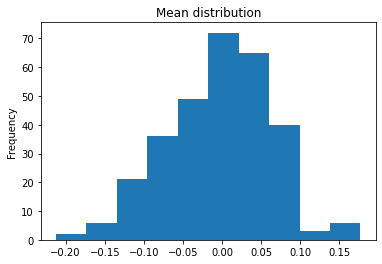

In [8]:
x.mean().plot(kind='hist')
plt.title('Mean distribution')

### Values in columns are more or less similar

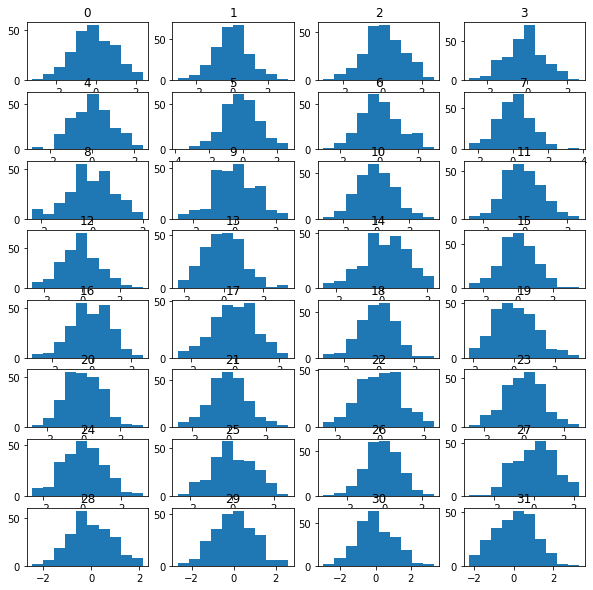

In [9]:
plt.figure(figsize=(10,10))
for i, col in enumerate(list(x.columns[:32])):
    plt.subplot(8 , 4, i+1)
    plt.hist(x[col])
    plt.title(col)

### Let's have a look at target data
target is binary and has some disbalance: 26% of samples belong to 1 class

In [10]:
y.value_counts()

0.0    183
1.0     67
Name: target, dtype: int64

In [11]:
y.value_counts(normalize=True)

0.0    0.732
1.0    0.268
Name: target, dtype: float64

### Let's have a look at correlations now!

But the question is how to analyse correlation for 300 column data!

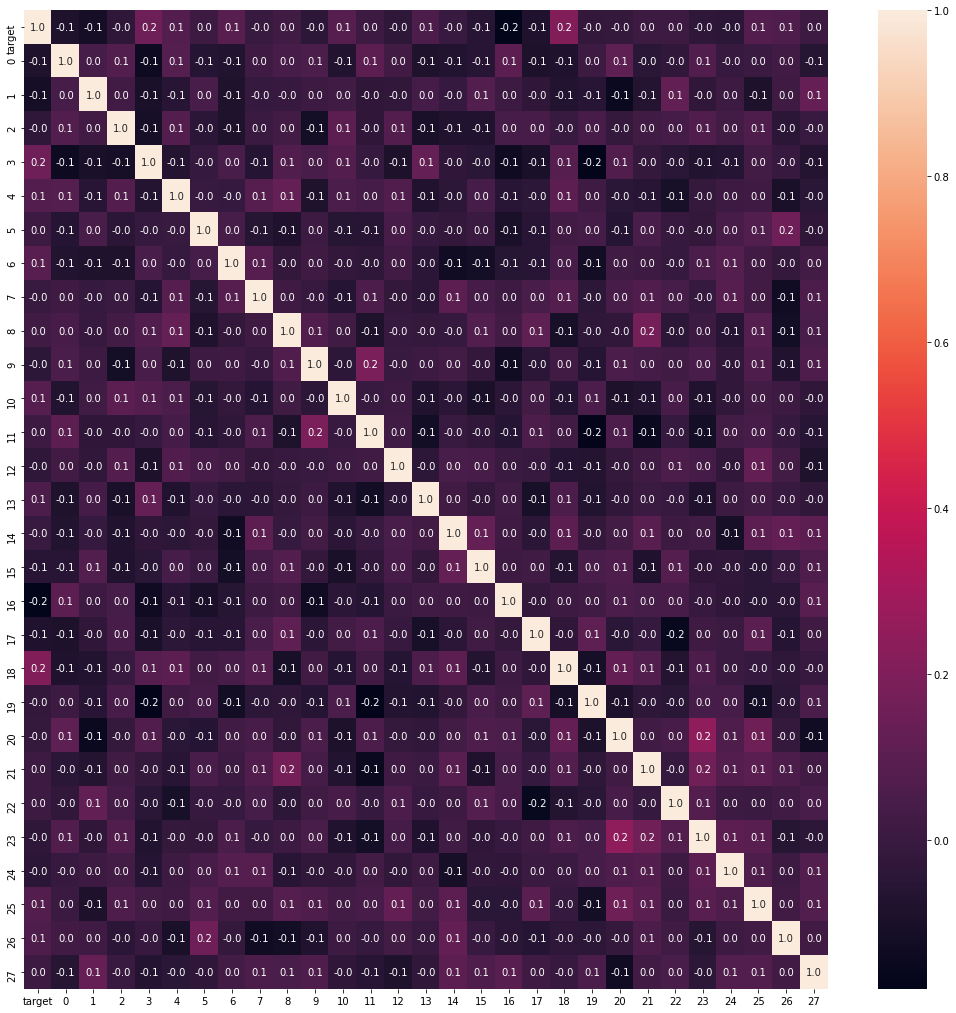

In [12]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train.iloc[:,1:30].corr(), annot=True, fmt= '.1f',ax=ax)

### Here is the solution!
Below code indicate TOP 10 correlation values

In [13]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,219,279,0.238512
90893,279,219,0.238512
90894,23,20,0.246984
90895,20,23,0.246984
90896,146,228,0.258447
90897,228,146,0.258447
90898,6,39,0.267727
90899,39,6,0.267727
90900,127,target,0.337540
90901,target,127,0.337540


### Basic Modelling

StandardScaler : It transforms the data in such a manner that it has mean as 0 and standard deviation as 1. In short, it standardizes the data. Standardization is useful for data which has negative values. It arranges the data in a standard normal distribution.

In [14]:
from sklearn.preprocessing import StandardScaler

X_train = x.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
y_train = y.copy()

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

### Acurracy of the model is 0.5%

### Let's Predict the model with Top 102 Correlation features wich has correlation value > 0.2

In [17]:
array = corrs.tail(129)['level_0'].unique()

In [18]:
x1 = x.loc[:,array]

In [19]:
x1.drop(columns=['id','target'], inplace=True)

In [20]:
X1_test = x_test.loc[:,array]

In [21]:
X1_test.drop(columns=['id','target'], inplace=True)

In [22]:
X1_train = x1.copy()
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

logreg = LogisticRegression()
logreg.fit(X1_train, y_train)
y1_pred = logreg.predict(X1_test)

### Still Accuracy is 0.5%

In [23]:
import eli5

In [24]:
eli5.show_weights(logreg, top=50)

Weight?,Feature
+1.178,x0
+0.984,x11
+0.957,x33
+0.690,x62
+0.678,x26
+0.678,x24
+0.651,x78
+0.562,x66
+0.548,x2
+0.537,x6


In [25]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(logreg).feature if 'BIAS' not in i]

In [26]:
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [28]:
from eli5.sklearn import PermutationImportance

In [29]:
perm = PermutationImportance(logreg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)

Weight,Feature
0.0472 ± 0.0265,x59
0.0352 ± 0.0255,x83
0.0352 ± 0.0514,x19
0.0304 ± 0.0289,x50
0.0288 ± 0.0318,x85
0.0264 ± 0.0261,x65
0.0240 ± 0.0209,x75
0.0224 ± 0.0109,x90
0.0216 ± 0.0241,x39
0.0208 ± 0.0128,x97


In [30]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Submittion 

In [32]:
y1_pred = pd.DataFrame(y1_pred)

In [33]:
y1_pred.rename(columns={0:'target'}, inplace=True)

In [34]:
sub = test['id']

In [35]:
submittion = pd.merge(sub, y1_pred, how='inner', left_index=True, right_index=True)

In [36]:
submittion.shape

(19750, 2)

In [37]:
submittion.head()

,id,target
0,250,0.0
1,251,0.0
2,252,1.0
3,253,1.0
4,254,0.0


In [38]:
#submittion.to_csv('Submittion_eli5_.csv', index=False)